**Author:** [Tayyib Ul Hassan](https://github.com/tayyibgondal)

**Dated:** February 6, 2023


# Introduction to TFDV

This tutorial illustrates how TensorFlow Data Validation (TFDV) can be used to investigate and visualize your dataset. That includes looking at descriptive statistics, inferring a schema, checking for and fixing anomalies, and checking for drift and skew in our dataset. It's important to understand your dataset's characteristics, including how it might change over time in your production pipeline. It's also important to look for anomalies in your data, and to compare your training, evaluation, and serving datasets to make sure that they're consistent.

TFDV helps to understand, validate, and monitor production machine learning data at scale. It provides insight into some key questions in the data analysis process such as:

- What are the underlying statistics of my data?

- What does my training dataset look like?

- How does my evaluation and serving datasets compare to the training dataset?

- How can I find and fix data anomalies?

The figure below summarizes the usual TFDV workflow:
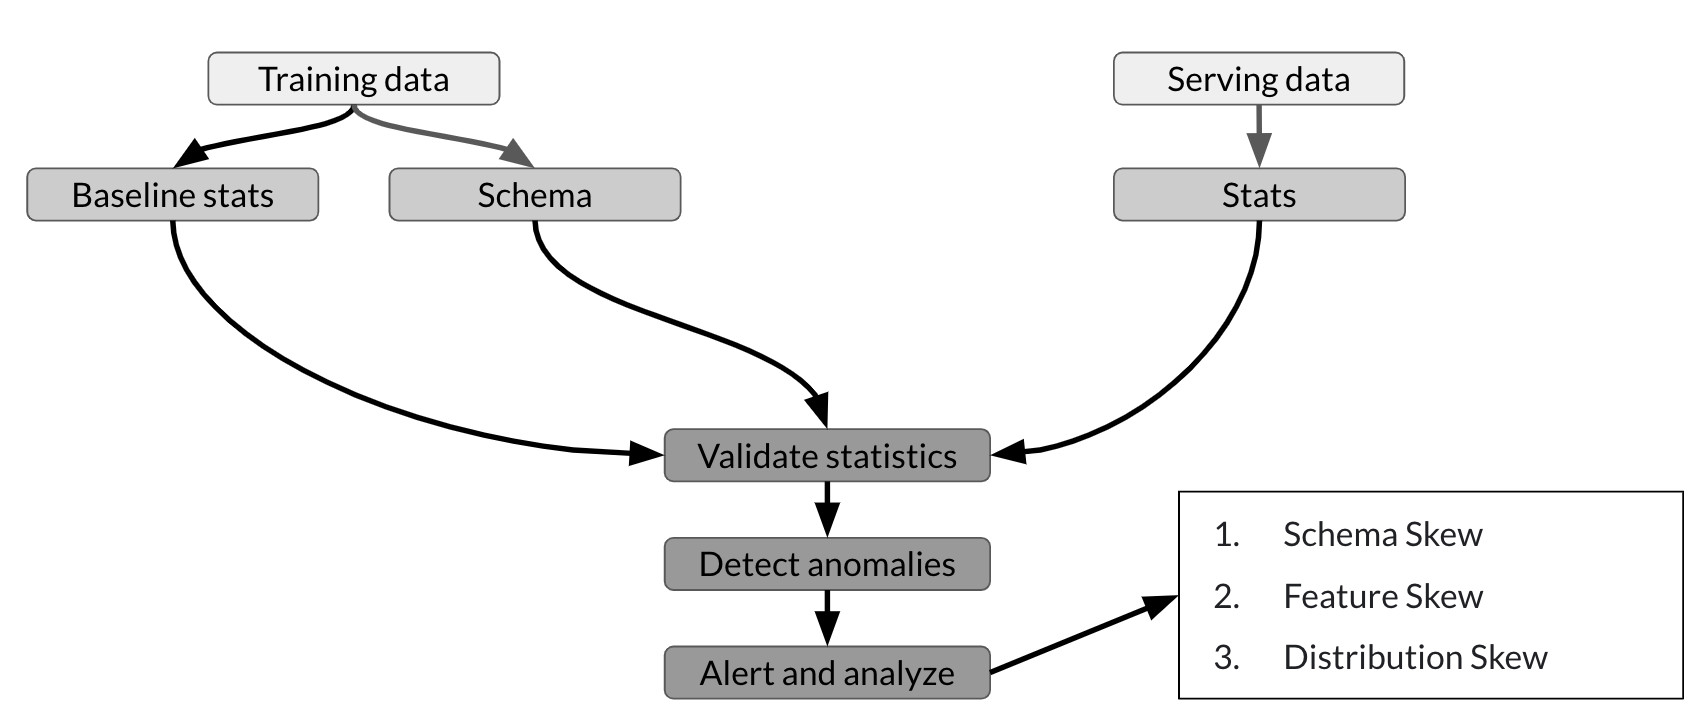

In this tutorial, I'll do the following:
1.  Generate and visualize statistics from a dataset
2. Detect and fix anomalies in an evaluation dataset

In [4]:
import tensorflow as tf
# !pip install tensorflow_data_validation
import tensorflow_data_validation as tfdv

import pandas as pd
from sklearn.model_selection import train_test_split

from tensorflow_metadata.proto.v0 import schema_pb2
print('TFDV Version: {}'.format(tfdv.__version__))
print('Tensorflow Version: {}'.format(tf.__version__))

TFDV Version: 1.14.0
Tensorflow Version: 2.15.0


## Loading the dataset

In [84]:
df = pd.read_csv('/content/adult.data', skipinitialspace=True)

train_df, eval_df = train_test_split(df, test_size=0.2, shuffle=False)

In [85]:
# Preview the train set
train_df.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,label
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


In [86]:
print(train_df.shape)


(26048, 15)


In [87]:
# Preview the eval set
eval_df.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,label
26048,30,Private,270886,Some-college,10,Never-married,Other-service,Own-child,White,Female,0,0,40,United-States,<=50K
26049,21,Private,216129,HS-grad,9,Never-married,Other-service,Own-child,White,Male,0,0,35,United-States,<=50K
26050,33,Private,189368,Some-college,10,Married-civ-spouse,Transport-moving,Husband,Black,Male,0,0,40,United-States,>50K
26051,19,?,141418,Some-college,10,Never-married,?,Own-child,White,Male,0,0,15,United-States,<=50K
26052,19,Private,306225,HS-grad,9,Never-married,Handlers-cleaners,Own-child,White,Male,0,0,25,United-States,<=50K


In [88]:
print(eval_df.shape)

(6513, 15)


From these few columns, you can get a first impression of the data. You will notice that most are strings and integers. There are also columns that are mostly zeroes. In the next sections, you will see how to use TFDV to aggregate and process this information so you can inspect it more easily.

## Adding anomolous rows in eval set

In [89]:
def add_extra_rows(df):
    rows = [
        {
            'age': 46,
            'fnlwgt': 257473,
            'education': 'Bachelors',
            'education-num': 8,
            'marital-status': 'Married-civ-spouse',
            'occupation': 'Plumber',
            'relationship': 'Husband',
            'race': 'Other',
            'sex': 'Male',
            'capital-gain': 1000,
            'capital-loss': 0,
            'hours-per-week': 41,
            'native-country': 'Australia',
            'label': '>50K'
        },
        {
            'age': 0,
            'workclass': 'Private',
            'fnlwgt': 257473,
            'education': 'Masters',
            'education-num': 8,
            'marital-status': 'Married-civ-spouse',
            'occupation': 'Adm-clerical',
            'relationship': 'Wife',
            'race': 'Asian',
            'sex': 'Female',
            'capital-gain': 0,
            'capital-loss': 0,
            'hours-per-week': 40,
            'native-country': 'Pakistan',
            'label': '>50K'
        },
        {
            'age': 1000,
            'workclass': 'Private',
            'fnlwgt': 257473,
            'education': 'Masters',
            'education-num': 8,
            'marital-status': 'Married-civ-spouse',
            'occupation': 'Prof-specialty',
            'relationship': 'Husband',
            'race': 'Black',
            'sex': 'Male',
            'capital-gain': 0,
            'capital-loss': 0,
            'hours-per-week': 20,
            'native-country': 'Cameroon',
            'label': '<=50K'
        },
        {
            'age': 25,
            'workclass': '?',
            'fnlwgt': 257473,
            'education': 'Masters',
            'education-num': 8,
            'marital-status': 'Married-civ-spouse',
            'occupation': 'gamer',
            'relationship': 'Husband',
            'race': 'Asian',
            'sex': 'Female',
            'capital-gain': 0,
            'capital-loss': 0,
            'hours-per-week': 50,
            'native-country': 'Mongolia',
            'label': '<=50K'
        }
    ]

    df = df.append(rows, ignore_index=True)

    return df

In [90]:
# add extra rows
eval_df = add_extra_rows(eval_df)

# preview the added rows
eval_df.tail(4)

<ipython-input-89-e4528a387e83>:72: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(rows, ignore_index=True)


,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,label
6513,46,NaN,257473,Bachelors,8,Married-civ-spouse,Plumber,Husband,Other,Male,1000,0,41,Australia,>50K
6514,0,Private,257473,Masters,8,Married-civ-spouse,Adm-clerical,Wife,Asian,Female,0,0,40,Pakistan,>50K
6515,1000,Private,257473,Masters,8,Married-civ-spouse,Prof-specialty,Husband,Black,Male,0,0,20,Cameroon,<=50K
6516,25,?,257473,Masters,8,Married-civ-spouse,gamer,Husband,Asian,Female,0,0,50,Mongolia,<=50K


## Generate and visualize training dataset statistics

Now i'll compute the statistics of training dataset. TFDV accepts three input formats: TensorFlow’s TFRecord, Pandas Dataframe, and CSV file.

In [91]:
# Generate training dataset statistics
train_stats = tfdv.generate_statistics_from_dataframe(train_df)

The results returned by this step for numerical and categorical data are summarized in this table:

| Numerical Data | Categorical Data   |
|:-:|:-:|
|Count of data records|Count of data records
|% of missing data records|% of missing data records|
|Mean, std, min, max|unique records|
|% of zero values|Avg string length|

In [92]:
# Visualize training dataset statistics
tfdv.visualize_statistics(train_stats)

## Infer data schema

Next step is to create a data schema to describe your train set. Simply put, a schema describes standard characteristics of your data such as column data types and expected data value range.

With the computed statistics, TFDV allows you to automatically generate an initial version of the schema using the [`infer_schema()`](https://www.tensorflow.org/tfx/data_validation/api_docs/python/tfdv/infer_schema) method. This returns a Schema [protocol buffer](https://developers.google.com/protocol-buffers) containing the result. As mentioned in the [TFX paper](http://stevenwhang.com/tfx_paper.pdf) (Section 3.3), the results of the schema inference can be summarized as follows:

* The expected type of each feature.
* The expected presence of each feature, in terms of a minimum count and fraction of examples that must contain
the feature.
* The expected valency of the feature in each example, i.e.,
minimum and maximum number of values.
* The expected domain of a feature, i.e., the small universe of
values for a string feature, or range for an integer feature.

In [93]:
# Infer schema from the computed statistics.
schema = tfdv.infer_schema(statistics=train_stats)

# Display the inferred schema
tfdv.display_schema(schema)

,Type,Presence,Valency,Domain
Feature name,,,,
'age',INT,required,,-
'workclass',STRING,required,,'workclass'
'fnlwgt',INT,required,,-
'education',STRING,required,,'education'
'education-num',INT,required,,-
'marital-status',STRING,required,,'marital-status'
'occupation',STRING,required,,'occupation'
'relationship',STRING,required,,'relationship'
'race',STRING,required,,'race'


,Values
Domain,
'workclass',"'?', 'Federal-gov', 'Local-gov', 'Never-worked', 'Private', 'Self-emp-inc', 'Self-emp-not-inc', 'State-gov', 'Without-pay'"
'education',"'10th', '11th', '12th', '1st-4th', '5th-6th', '7th-8th', '9th', 'Assoc-acdm', 'Assoc-voc', 'Bachelors', 'Doctorate', 'HS-grad', 'Masters', 'Preschool', 'Prof-school', 'Some-college'"
'marital-status',"'Divorced', 'Married-AF-spouse', 'Married-civ-spouse', 'Married-spouse-absent', 'Never-married', 'Separated', 'Widowed'"
'occupation',"'?', 'Adm-clerical', 'Armed-Forces', 'Craft-repair', 'Exec-managerial', 'Farming-fishing', 'Handlers-cleaners', 'Machine-op-inspct', 'Other-service', 'Priv-house-serv', 'Prof-specialty', 'Protective-serv', 'Sales', 'Tech-support', 'Transport-moving'"
'relationship',"'Husband', 'Not-in-family', 'Other-relative', 'Own-child', 'Unmarried', 'Wife'"
'race',"'Amer-Indian-Eskimo', 'Asian-Pac-Islander', 'Black', 'Other', 'White'"
'sex',"'Female', 'Male'"
'native-country',"'?', 'Cambodia', 'Canada', 'China', 'Columbia', 'Cuba', 'Dominican-Republic', 'Ecuador', 'El-Salvador', 'England', 'France', 'Germany', 'Greece', 'Guatemala', 'Haiti', 'Holand-Netherlands', 'Honduras', 'Hong', 'Hungary', 'India', 'Iran', 'Ireland', 'Italy', 'Jamaica', 'Japan', 'Laos', 'Mexico', 'Nicaragua', 'Outlying-US(Guam-USVI-etc)', 'Peru', 'Philippines', 'Poland', 'Portugal', 'Puerto-Rico', 'Scotland', 'South', 'Taiwan', 'Thailand', 'Trinadad&Tobago', 'United-States', 'Vietnam', 'Yugoslavia'"
'label',"'<=50K', '>50K'"


The next step after generating the schema is to now look at the evaluation dataset. You will begin by computing its statistics then compare it with the training statistics. It is important that the numerical and categorical features of the evaluation data belongs roughly to the same range as the training data. Otherwise, you might have distribution skew that will negatively affect the accuracy of your model.

TFDV allows you to generate both the training and evaluation dataset statistics side-by-side. You can use the [`visualize_statistics()`](https://www.tensorflow.org/tfx/data_validation/api_docs/python/tfdv/visualize_statistics) function and pass additional parameters to overlay the statistics from both datasets (referenced as left-hand side and right-hand side statistics). Let's see what these parameters are:

- `lhs_statistics`: Required parameter. Expects an instance of `DatasetFeatureStatisticsList `.


- `rhs_statistics`: Expects an instance of `DatasetFeatureStatisticsList ` to compare with `lhs_statistics`.


- `lhs_name`: Name of the `lhs_statistics` dataset.


- `rhs_name`: Name of the `rhs_statistics` dataset.

In [94]:
# Generate evaluation dataset statistics
eval_stats = tfdv.generate_statistics_from_dataframe(eval_df)

# Compare training with evaluation
tfdv.visualize_statistics(
    lhs_statistics=eval_stats,
    rhs_statistics=train_stats,
    lhs_name='EVAL_DATASET',
    rhs_name='TRAIN_DATASET'
)

## Calculate and display evaluation anomalies

You can use your reference schema to check for anomalies such as new values for a specific feature in the evaluation data. Detected anomalies can either be considered a real error that needs to be cleaned, or depending on your domain knowledge and the specific case, they can be accepted.

Let's detect and display evaluation anomalies and see if there are any problems that need to be addressed.

In [95]:
# Check evaluation data for errors by validating the evaluation dataset statistics using the reference schema
anomalies =  tfdv.validate_statistics(statistics=eval_stats, schema=schema)

# Visualize anomalies
tfdv.display_anomalies(anomalies)

,Anomaly short description,Anomaly long description
Feature name,,
'workclass',Multiple errors,"The feature has a shape, but it's not always present (if the feature is nested, then it should always be present at each nested level) or its value lengths vary. The feature was present in fewer examples than expected: minimum fraction = 1.000000, actual = 0.999847"
'__index_level_0__',Column dropped,Column is completely missing
'native-country',Unexpected string values,"Examples contain values missing from the schema: Australia (<1%), Cameroon (<1%), Mongolia (<1%), Pakistan (<1%)."
'occupation',Unexpected string values,"Examples contain values missing from the schema: Plumber (<1%), gamer (<1%)."
'race',Unexpected string values,Examples contain values missing from the schema: Asian (<1%).


## Revising the schema

Let's say that we want to accept the string anomalies reported as valid. If you want to tolerate a fraction of missing values from the evaluation dataset, you can do it like this:

In [98]:
# Relax the minimum fraction of values that must come from the domain for the feature `native-country`
country_feature = tfdv.get_feature(schema, 'native-country')
country_feature.distribution_constraints.min_domain_mass = 0.9

# Relax the minimum fraction of values that must come from the domain for the feature `occupation`
occupation_feature = tfdv.get_feature(schema, 'occupation')
occupation_feature.distribution_constraints.min_domain_mass = 0.9

If you want to be rigid and instead add only valid values to the domain, you can do it like this:

In [99]:
race_domain = tfdv.get_domain(schema, 'race')
race_domain.value.append('Asian')

In addition, you can also restrict the range of a numerical feature. This will let you know of invalid values without having to inspect it visually.

In [100]:
# Restrict the range of the `age` feature
tfdv.set_domain(schema, 'age', schema_pb2.IntDomain(name='age', min=17, max=90))

# Display the modified schema. Notice the `Domain` column of `age`.
tfdv.display_schema(schema)

,Type,Presence,Valency,Domain
Feature name,,,,
'age',INT,required,,min: 17; max: 90
'workclass',STRING,required,,'workclass'
'fnlwgt',INT,required,,-
'education',STRING,required,,'education'
'education-num',INT,required,,-
'marital-status',STRING,required,,'marital-status'
'occupation',STRING,required,,'occupation'
'relationship',STRING,required,,'relationship'
'race',STRING,required,,'race'


,Values
Domain,
'workclass',"'?', 'Federal-gov', 'Local-gov', 'Never-worked', 'Private', 'Self-emp-inc', 'Self-emp-not-inc', 'State-gov', 'Without-pay'"
'education',"'10th', '11th', '12th', '1st-4th', '5th-6th', '7th-8th', '9th', 'Assoc-acdm', 'Assoc-voc', 'Bachelors', 'Doctorate', 'HS-grad', 'Masters', 'Preschool', 'Prof-school', 'Some-college'"
'marital-status',"'Divorced', 'Married-AF-spouse', 'Married-civ-spouse', 'Married-spouse-absent', 'Never-married', 'Separated', 'Widowed'"
'occupation',"'?', 'Adm-clerical', 'Armed-Forces', 'Craft-repair', 'Exec-managerial', 'Farming-fishing', 'Handlers-cleaners', 'Machine-op-inspct', 'Other-service', 'Priv-house-serv', 'Prof-specialty', 'Protective-serv', 'Sales', 'Tech-support', 'Transport-moving'"
'relationship',"'Husband', 'Not-in-family', 'Other-relative', 'Own-child', 'Unmarried', 'Wife'"
'race',"'Amer-Indian-Eskimo', 'Asian-Pac-Islander', 'Black', 'Other', 'White', 'Asian'"
'sex',"'Female', 'Male'"
'native-country',"'?', 'Cambodia', 'Canada', 'China', 'Columbia', 'Cuba', 'Dominican-Republic', 'Ecuador', 'El-Salvador', 'England', 'France', 'Germany', 'Greece', 'Guatemala', 'Haiti', 'Holand-Netherlands', 'Honduras', 'Hong', 'Hungary', 'India', 'Iran', 'Ireland', 'Italy', 'Jamaica', 'Japan', 'Laos', 'Mexico', 'Nicaragua', 'Outlying-US(Guam-USVI-etc)', 'Peru', 'Philippines', 'Poland', 'Portugal', 'Puerto-Rico', 'Scotland', 'South', 'Taiwan', 'Thailand', 'Trinadad&Tobago', 'United-States', 'Vietnam', 'Yugoslavia'"
'label',"'<=50K', '>50K'"


With these revisions, running the validation should now show no anomalies.

In [101]:
updated_anomalies = tfdv.validate_statistics(eval_stats, schema)
tfdv.display_anomalies(updated_anomalies)

,Anomaly short description,Anomaly long description
Feature name,,
'age',Multiple errors,Unexpectedly small value: 0. Unexpectedly large value: 1000.
'workclass',Multiple errors,"The feature has a shape, but it's not always present (if the feature is nested, then it should always be present at each nested level) or its value lengths vary. The feature was present in fewer examples than expected: minimum fraction = 1.000000, actual = 0.999847"
'__index_level_0__',Column dropped,Column is completely missing


Ooops, there are still some anomalies. Let's *update the dataset* to remove these, instead of revising schema.


In [108]:
# filter the age range
eval_df = eval_df[eval_df['age'] > 16]
eval_df = eval_df[eval_df['age'] < 91]

# drop missing values
eval_df.dropna(inplace=True)

eval_stats = tfdv.generate_statistics_from_dataframe(eval_df)

In [109]:
updated_anomalies = tfdv.validate_statistics(eval_stats, schema)
tfdv.display_anomalies(updated_anomalies)

## Examining dataset slices

TFDV also allows you to analyze specific slices of your dataset. This is particularly useful if you want to inspect if a feature type is well-represented in your dataset. Let's walk through an example where we want to compare the statistics for male and female participants.

First, you will use the [`get_feature_value_slicer`](https://github.com/tensorflow/data-validation/blob/master/tensorflow_data_validation/utils/slicing_util.py#L48) method from the `slicing_util` to get the features you want to examine. You can specify that by passing a dictionary to the `features` argument. If you want to get the entire domain of a feature, then you can map the feature name with `None` as shown below. This means that you will get slices for both `Male` and `Female` entries. This returns a function that can be used to extract the said feature slice.

In [111]:
from tensorflow_data_validation.utils import slicing_util

slice_fn = slicing_util.get_feature_value_slicer(features={'sex': None})

With the slice function ready, you can now generate the statistics. You need to tell TFDV that you need statistics for the features you set and you can do that through the `slice_functions` argument of [`tfdv.StatsOptions`](https://www.tensorflow.org/tfx/data_validation/api_docs/python/tfdv/StatsOptions). Let's prepare that in the cell below. Notice that you also need to pass in the schema.

In [112]:
slice_stats_options = tfdv.StatsOptions(schema=schema,
                                        slice_functions=[slice_fn],
                                        infer_type_from_schema=True)

In [115]:
# Convert dataframe to CSV since `slice_functions` works only with `tfdv.generate_statistics_from_csv`
CSV_PATH = 'slice_sample.csv'
train_df.to_csv(CSV_PATH)

# Calculate statistics for the sliced dataset
sliced_stats = tfdv.generate_statistics_from_csv(CSV_PATH, stats_options=slice_stats_options)

Instructions for updating:
Use eager execution and: 
`tf.data.TFRecordDataset(path)`


With that, you now have the statistics for the set slice. These are packed into a `DatasetFeatureStatisticsList` protocol buffer. You can see the dataset names below. The first element in the list (i.e. index=0) is named `All_Examples` which just contains the statistics for the entire dataset. The next two elements (i.e. named `sex_Male` and `sex_Female`) are the datasets that contain the stats for the slices. It is important to note that these datasets are of the type: `DatasetFeatureStatistics`. You will see why this is important after the cell below.

In [116]:
print(f'Datasets generated: {[sliced.name for sliced in sliced_stats.datasets]}')

print(f'Type of sliced_stats elements: {type(sliced_stats.datasets[0])}')

Datasets generated: ['All Examples', 'sex_Male', 'sex_Female']
Type of sliced_stats elements: <class 'tensorflow_metadata.proto.v0.statistics_pb2.DatasetFeatureStatistics'>


You can then visualize the statistics as before to examine the slices. An important caveat is `visualize_statistics()` accepts a `DatasetFeatureStatisticsList` type instead of `DatasetFeatureStatistics`. Thus, at least for this version of TFDV, you will need to convert it to the correct type.



In [118]:
from tensorflow_metadata.proto.v0.statistics_pb2 import DatasetFeatureStatisticsList

# Convert `Male` statistics (index=1) to the correct type and get the dataset name
male_stats_list = DatasetFeatureStatisticsList()
male_stats_list.datasets.extend([sliced_stats.datasets[1]])
male_stats_name = sliced_stats.datasets[1].name

# Convert `Female` statistics (index=2) to the correct type and get the dataset name
female_stats_list = DatasetFeatureStatisticsList()
female_stats_list.datasets.extend([sliced_stats.datasets[2]])
female_stats_name = sliced_stats.datasets[2].name

# Visualize the two slices side by side
tfdv.visualize_statistics(
    lhs_statistics=male_stats_list,
    rhs_statistics=female_stats_list,
    lhs_name=male_stats_name,
    rhs_name=female_stats_name
)

* If you want to be more specific, then you can map the specific value to the feature name. For example, if you want just `Male`, then you can declare it as `features={'sex': [b'Male']}`. Notice that the string literal needs to be passed in as bytes with the `b'` prefix.

* You can also pass in several features if you want. For example, if you want to slice through both the `sex` and `race` features, then you can do `features={'sex': None, 'race': None}`.


**References**

- https://www.tensorflow.org/tfx/data_validation/
- https://www.deeplearning.ai/